# augmentation을 적용한 함수 dl모델을 제작

데이터 증강 함수
- A.Resize(height=256, width=256) : 사이즈 변경
- A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) : 이미지 픽셀 정규화
- A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16) : 픽셀 드롭아웃(구멍뚫기)
- A.Rotate(limit=(115, 115), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0) : 비율 유지하여 회전, 빈공간 흰색
- A.VerticalFlip(always_apply=False, p=0.5) : 좌우반전
- A.HorizontalFlip(always_apply=False, p=1.0) : 상하반전
- A.Blur(always_apply=True, p=1.0, blur_limit=(3, 7)) : 블러
- A.GaussNoise(always_apply=False, p=1.0, var_limit=(10.0, 50.0)) : 가우시안, 되는지 의문
- A.Downscale(always_apply=False, p=1.0, scale_min=0.35, scale_max=0.35, interpolation=0) : 픽셀다운, 모자이크
- 믹스 추가필요

In [7]:
# wandb 연결
import wandb

In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wpdn0134 (je_). Use `wandb login --relogin` to force relogin


True

In [1]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import cv2
import matplotlib.pyplot as plt

from itertools import combinations

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    

In [4]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, vaild_loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    vaild_preds_list = []
    vaild_target_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.float().to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # vaildation set predict
    model.eval()
    for image, target in tqdm(vaild_loader):
        image = image.float().to(device)

        with torch.no_grad():
            preds = model(image)
        vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        vaild_target_list.extend(target.detach().cpu().numpy())
    vaild_acc = accuracy_score(vaild_target_list, vaild_preds_list)
    vaild_f1 = f1_score(vaild_target_list, vaild_preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "vaild_acc": vaild_acc,
        "vaild_f1": vaild_f1,
    }

    return ret

In [5]:
# vaild_preds_list = []
# vaild_target_list = []

# model.eval()
# for image, target in tqdm(vaild_loader):
#     image = image.float().to(device)

#     with torch.no_grad():
#         preds = model(image)
#     vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
#     vaild_target_list.extend(target.detach().cpu().numpy())
# vaild_acc = accuracy_score(vaild_target_list, preds_list)
# vaild_f1 = f1_score(vaild_target_list, preds_list, average='macro')

In [5]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 256
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

- 일단 단일 augmentation들로 확인
- 성능향상시 다양한 데이터증강을 조합하여 추가학습

In [7]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])
# trn_transform_coarseDropout = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate45 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate90 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate135 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate180 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate225 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate270 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate315 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_verticalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.VerticalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_horizontalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.HorizontalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_blur = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Blur(always_apply=True, p=1.0, blur_limit=(3, 3)),
#     ToTensorV2(),
# ])
# trn_transform_gaussnoise = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.GaussNoise(always_apply=False, p=1.0, var_limit=(500.0, 500.0)),
#     ToTensorV2(),
# ])
# trn_transform_downscale = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Downscale(always_apply=False, p=1.0, scale_min=0.5, scale_max=0.5, interpolation=0),
#     ToTensorV2(),
# ])
# transform_list = [trn_transform, trn_transform_coarseDropout, trn_transform_rotate45, trn_transform_rotate90, trn_transform_rotate135, trn_transform_rotate180, trn_transform_rotate225,
#                   trn_transform_rotate270, trn_transform_rotate315, trn_transform_verticalflip, trn_transform_horizontalflip, trn_transform_blur, trn_transform_gaussnoise,
#                   trn_transform_downscale]

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [6]:
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_list = [A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
                  A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(0, 360), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.VerticalFlip(always_apply=False, p=1),
                  A.HorizontalFlip(always_apply=False, p=1),
                  A.Blur(always_apply=True, p=1, blur_limit=(3, 3)),
                  A.GaussNoise(always_apply=False, p=1, var_limit=(0.2, 0.2)),
                  A.Downscale(always_apply=False, p=1, scale_min=0.5, scale_max=0.5, interpolation=0),]

tst_transform = A.Compose([ 
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [25]:
# transform_list에서 2개 조합으로 데이터 증강
for a, b in combinations(transform_list, 2):
    print(a, b, end="\n")

CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(45, 45), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(90, 90), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(135, 135), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropo

In [9]:
# Dataset 정의를 위한 함수
def make_dataset(transform_list, csv, path):
    trn_dataset = ImageDataset(
        csv,
        path,
        # transform=transform_list[0]
        transform = trn_transform
    )
    for transform in transform_list:
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transform,
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

    for transform1, transform2 in combinations(transform_list, 2):
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transform1,
                transform2,
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])


    return trn_dataset

In [12]:
# # vaildation set 정의
# def make_vaild_dataset(transform_list, csv, path):
#     trn_dataset = ImageDataset(
#         csv,
#         path,
#         transform=transform_list[0]
#     )
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform_list[0],
#                 ToTensorV2()
#             ])
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])
    
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform,
#                 ToTensorV2()
#             ])
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

#     for transform1, transform2 in combinations(transform_list, 2):
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform1,
#                 transform2,
#                 ToTensorV2()
#             ])
#         )

#     return trn_dataset

In [10]:
trn_dataset = make_dataset(transform_list, "../datasets_fin/divided_train.csv", "../datasets_fin/train/")
vaild_dataset = make_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/",)
tst_dataset = ImageDataset(
    "../datasets_fin/test.csv",
    "../datasets_fin/train/",
    transform=tst_transform
)
print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

115552 14444 157


In [28]:
# Dataset 정의를 위한 함수
# trn_dataset = ImageDataset(
#     "../datasets_fin/divided_train.csv",
#     "../datasets_fin/train/",
#     transform=trn_transform
# )
# vaild_dataset = make_vaild_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/")
# tst_dataset = ImageDataset(
#     "../datasets_fin/test.csv",
#     "../datasets_fin/train/",
#     transform=tst_transform
# )
# print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

115552 14444 157


In [11]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
vaild_loader = DataLoader(
    vaild_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [17]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [18]:
early_stop = 0
best_model = model
best_epoch = 0
best_vaild_f1 = 0
resent_model = model
before_vaild_f1 = 0
for epoch in range(EPOCHS):
   
   ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
   ret['epoch'] = epoch
   if before_vaild_f1 < ret['vaild_f1']:
      if best_vaild_f1 < ret['vaild_f1']:
         best_vaild_f1 = ret['vaild_f1']
         best_model = model
         best_epoch = epoch+1
      resent_model = model
      early_stop = 0
   else:
      early_stop += 1
   before_vaild_f1 = ret['vaild_f1']

   print(early_stop)

   log = ""
   for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
   print(log)

   if early_stop > 2: # earlystop없이 모든 애폭을 사용하여 학습, 단 best model을 따로 저장
      torch.save(best_model, '../model/best_augmentation8_'+str(img_size)+'_'+str(best_epoch)+'.pt')
      break

100%|██████████| 452/452 [01:20<00:00,  5.60it/s]


0
train_loss: 0.2559
train_acc: 0.9096
train_f1: 0.9050
vaild_acc: 0.7700
vaild_f1: 0.7448
epoch: 0.0000



100%|██████████| 452/452 [01:20<00:00,  5.64it/s]


0
train_loss: 0.0441
train_acc: 0.9851
train_f1: 0.9845
vaild_acc: 0.8741
vaild_f1: 0.8668
epoch: 1.0000



100%|██████████| 452/452 [01:20<00:00,  5.62it/s]


1
train_loss: 0.0292
train_acc: 0.9904
train_f1: 0.9901
vaild_acc: 0.8578
vaild_f1: 0.8443
epoch: 2.0000



100%|██████████| 452/452 [01:20<00:00,  5.61it/s]


0
train_loss: 0.0199
train_acc: 0.9935
train_f1: 0.9932
vaild_acc: 0.8926
vaild_f1: 0.8876
epoch: 3.0000



100%|██████████| 452/452 [01:20<00:00,  5.63it/s]


1
train_loss: 0.0172
train_acc: 0.9945
train_f1: 0.9943
vaild_acc: 0.8701
vaild_f1: 0.8610
epoch: 4.0000



100%|██████████| 452/452 [01:20<00:00,  5.62it/s]


0
train_loss: 0.0129
train_acc: 0.9960
train_f1: 0.9958
vaild_acc: 0.8855
vaild_f1: 0.8724
epoch: 5.0000



100%|██████████| 452/452 [01:20<00:00,  5.59it/s]


1
train_loss: 0.0109
train_acc: 0.9966
train_f1: 0.9965
vaild_acc: 0.8703
vaild_f1: 0.8611
epoch: 6.0000



100%|██████████| 452/452 [01:20<00:00,  5.61it/s]


0
train_loss: 0.0108
train_acc: 0.9968
train_f1: 0.9967
vaild_acc: 0.9035
vaild_f1: 0.8964
epoch: 7.0000



100%|██████████| 452/452 [01:20<00:00,  5.62it/s]


0
train_loss: 0.0087
train_acc: 0.9972
train_f1: 0.9971
vaild_acc: 0.9000
vaild_f1: 0.8965
epoch: 8.0000



100%|██████████| 452/452 [01:20<00:00,  5.60it/s]


1
train_loss: 0.0076
train_acc: 0.9975
train_f1: 0.9975
vaild_acc: 0.8965
vaild_f1: 0.8912
epoch: 9.0000



100%|██████████| 452/452 [01:20<00:00,  5.60it/s]


0
train_loss: 0.0068
train_acc: 0.9979
train_f1: 0.9978
vaild_acc: 0.9031
vaild_f1: 0.8998
epoch: 10.0000



100%|██████████| 452/452 [01:20<00:00,  5.62it/s]


0
train_loss: 0.0063
train_acc: 0.9981
train_f1: 0.9979
vaild_acc: 0.9088
vaild_f1: 0.9070
epoch: 11.0000



100%|██████████| 452/452 [01:20<00:00,  5.60it/s]


1
train_loss: 0.0052
train_acc: 0.9984
train_f1: 0.9984
vaild_acc: 0.8664
vaild_f1: 0.8590
epoch: 12.0000



100%|██████████| 452/452 [01:20<00:00,  5.61it/s]


0
train_loss: 0.0061
train_acc: 0.9983
train_f1: 0.9982
vaild_acc: 0.9020
vaild_f1: 0.9004
epoch: 13.0000



100%|██████████| 452/452 [01:20<00:00,  5.61it/s]


1
train_loss: 0.0052
train_acc: 0.9984
train_f1: 0.9984
vaild_acc: 0.9065
vaild_f1: 0.8990
epoch: 14.0000



100%|██████████| 452/452 [01:20<00:00,  5.58it/s]


2
train_loss: 0.0054
train_acc: 0.9985
train_f1: 0.9984
vaild_acc: 0.8986
vaild_f1: 0.8923
epoch: 15.0000



100%|██████████| 452/452 [01:20<00:00,  5.62it/s]


3
train_loss: 0.0050
train_acc: 0.9984
train_f1: 0.9982
vaild_acc: 0.7809
vaild_f1: 0.7868
epoch: 16.0000



In [40]:
# 베스트 모델 저장
torch.save(best_model, '../model/best_augmentation6_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [38]:
# 마지막 모델 저장
torch.save(model, '../model/augmentation6_'+str(img_size)+'_'+str(epoch+1)+'.pt')

In [16]:
# for epoch in range(20):
#     ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

마지막 학습한 모델의 데이터셋 확인 및 실제 데이터 추측

In [39]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


(0.910828025477707, 0.9061289587605378)

In [40]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [41]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:15<00:00,  6.42it/s]


In [42]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [43]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [44]:
pred_df.to_csv("../output/augmentation6_lastmodel_pred_256_"+str(epoch+1)+".csv", index=False)

In [45]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,7
4,00901f504008d884.jpg,2


best case의 test set확인 및 실제 데이터 추측

In [19]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_augmentation8_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [20]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


(0.9235668789808917, 0.9134611930896761)

In [21]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [22]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:14<00:00,  7.01it/s]


In [23]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [24]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [28]:
pred_df.to_csv("../output/augmentation8_pred_256_"+str(best_epoch)+".csv", index=False)

In [26]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,1
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,10
4,00901f504008d884.jpg,2


최선 경우와 마지막 경우가 같은 예측을 함

In [55]:
a = pd.read_csv("../output/augmentation6_pred_256_"+str(best_epoch)+".csv")
b = pd.read_csv("../output/augmentation6_lastmodel_pred_256_"+str(epoch+1)+".csv")

In [59]:
sum(a['target'] == b['target'])

3140

In [61]:
len(a['target'])

3140

best case의 경우 tst set을 다양한 증강을 더해 검증

In [29]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_augmentation8_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [30]:
tst_dataset2 = make_dataset(transform_list, "../datasets_fin/test.csv", "../datasets_fin/train/",)

print(len(tst_dataset2))

14444


In [16]:
i1, i2 = tst_dataset2.__getitem__(0)
i1, i2

(tensor([[[-1.8782, -1.8097, -1.8439,  ...,  1.2557,  1.2385,  1.2214],
          [-1.7754, -1.8268, -1.8439,  ...,  1.2728,  1.2557,  1.2557],
          [-1.8097, -1.8097, -1.7754,  ...,  1.3070,  1.2899,  1.2728],
          ...,
          [-1.8610, -1.8268, -1.8268,  ..., -1.8439, -1.8268, -1.8439],
          [-1.8610, -1.8610, -1.8782,  ..., -1.8782, -1.8097, -1.8439],
          [-1.8782, -1.8782, -1.8953,  ..., -1.8782, -1.8610, -1.8610]],
 
         [[-1.8256, -1.7906, -1.8256,  ...,  1.4132,  1.3957,  1.3782],
          [-1.7381, -1.8081, -1.8256,  ...,  1.4307,  1.4132,  1.4132],
          [-1.7556, -1.7906, -1.7731,  ...,  1.4657,  1.4482,  1.4307],
          ...,
          [-1.8081, -1.7731, -1.7556,  ..., -1.8256, -1.8081, -1.8256],
          [-1.8081, -1.7731, -1.7731,  ..., -1.8081, -1.7906, -1.8256],
          [-1.8081, -1.7906, -1.7906,  ..., -1.8081, -1.8081, -1.8256]],
 
         [[-1.5779, -1.5430, -1.5779,  ...,  1.6291,  1.6117,  1.5942],
          [-1.4907, -1.5604,

In [31]:
tst_loader2 = DataLoader(
    tst_dataset2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [32]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []
# tst_img = []

model.eval()
for image, target in tqdm(tst_loader2):
    # tst_img.extend(image.permute(1, 2, 0).detach().cpu().numpy())
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 452/452 [01:21<00:00,  5.57it/s]


(0.7973553032400997, 0.7932611356474142)

In [33]:
# 예측에 사용된 이미지 추출하여 리스트에 저장
tst_img = []
for idx in range(tst_dataset2.__len__()):
# for idx in range(1):
    img, target = tst_dataset2.__getitem__(idx)
    tst_img.append(img.permute(1, 2, 0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


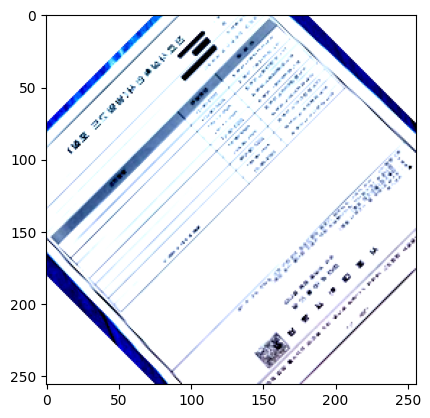

In [34]:
# 저장한 이미지 확인
plt.imshow(tst_img[12345])
plt.show()

In [35]:
tst_df = pd.DataFrame({
    'img' : tst_img,
    'target' : tst_target_list,
    'predict' : tst_preds_list
})

In [36]:
# 맞춘 개수
(tst_df['predict'] == tst_df['target']).sum()

11517

In [37]:
# 틀린 개수
(~(tst_df['predict'] == tst_df['target'])).sum()

2927

In [38]:
tst_df[~(tst_df['predict'] == tst_df['target'])]

,img,target,predict
29,"[[[0.67343086, 0.8879551, 1.1236601], [0.67343...",3,7
36,"[[[1.4611695, 1.6757703, 1.9776906], [1.444044...",7,3
43,"[[[0.5535576, 0.8179271, 1.2108061], [0.724805...",11,10
68,"[[[0.6220566, 1.0630251, 1.5942483], [0.604931...",7,3
70,"[[[-0.6622999, -0.26750696, 0.23477125], [-0.6...",7,3
...,...,...,...
14437,"[[[0.2589247, 1.0, 1.0], [0.2589247, 1.0, 1.0]...",11,16
14438,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",5,16
14440,"[[[0.0, 0.0, 0.5441721], [0.0, 0.0, 0.5441721]...",4,3
14441,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",9,16


In [39]:
i = pd.read_csv('../datasets_fin/test.csv')
i

,ID,target
0,02d404271e4965fa.jpg,15
1,03648b6855b9f8c1.jpg,10
2,0482c84f6e50fc44.jpg,5
3,05c521f2659c0711.jpg,16
4,0664699c12c8162c.jpg,11
...,...,...
152,e8e8dd06a96f2586.jpg,16
153,e985d6cb79c79810.jpg,4
154,ea379b41d59cec36.jpg,9
155,ebdb6f14d9876caa.jpg,8


In [40]:
# 각 예측의 이미지 id 추가
tst_df['ID'] = list(i['ID']) * 92

In [41]:
tst_df

,img,target,predict,ID
0,"[[[-1.8781574, -1.8256301, -1.5778649], [-1.80...",15,15,02d404271e4965fa.jpg
1,"[[[0.89605266, 1.1855742, 1.4373856], [0.89605...",10,10,03648b6855b9f8c1.jpg
2,"[[[-0.38830385, 0.047619067, 0.47877997], [-0....",5,5,0482c84f6e50fc44.jpg
3,"[[[0.17681302, 0.4327731, 0.844793], [0.142563...",16,16,05c521f2659c0711.jpg
4,"[[[0.57068235, 0.3977591, 0.21734206], [0.7076...",11,11,0664699c12c8162c.jpg
...,...,...,...,...
14439,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",16,16,e8e8dd06a96f2586.jpg
14440,"[[[0.0, 0.0, 0.5441721], [0.0, 0.0, 0.5441721]...",4,3,e985d6cb79c79810.jpg
14441,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",9,16,ea379b41d59cec36.jpg
14442,"[[[0.92098033, 1.0, 1.0], [0.92098033, 1.0, 1....",8,2,ebdb6f14d9876caa.jpg


In [42]:
def get_item(idx):
    image, target, predict, name = tst_df.loc[idx,]
    img = np.array(Image.open(os.path.join("../datasets_fin/train/", name)))

    # img = trn_transform(image=img)['image']
    return img, target, name, predict, image

In [43]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('target')

target
7     472
4     466
3     370
14    290
11    267
12    251
6     214
10    106
9     102
8      95
5      84
13     74
15     71
1      58
2       3
0       2
16      2
Name: count, dtype: int64

In [44]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('predict')

predict
7     881
3     616
16    392
10    306
2     172
1     162
4     139
14    104
13     98
0      25
6       8
12      8
11      6
15      5
5       4
9       1
Name: count, dtype: int64

In [47]:
qw = tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == 7)]
qw

,img,target,predict,ID
36,"[[[1.4611695, 1.6757703, 1.9776906], [1.444044...",7,3,2e939381a84d19cf.jpg
68,"[[[0.6220566, 1.0630251, 1.5942483], [0.604931...",7,3,4e5848a4ad483009.jpg
70,"[[[-0.6622999, -0.26750696, 0.23477125], [-0.6...",7,3,4f1a0debe89c7641.jpg
99,"[[[-0.54242665, 0.10014007, 0.844793], [-0.730...",7,3,a376fbdb67bc4a92.jpg
100,"[[[0.9303022, 1.1330532, 1.4373856], [0.998801...",7,4,aac6d02aa2f222af.jpg
...,...,...,...,...
14286,"[[[1.0102177, 1.1972455, 1.3967174], [1.010217...",7,3,f9bfe5eae7d723ce.jpg
14310,"[[[0.0, 0.0, 0.094373226], [0.0, 0.0, 0.094373...",7,3,1e5bf6fe5e8686d6.jpg
14323,"[[[0.7984081, 1.0, 1.0], [0.7984081, 1.0, 1.0]...",7,3,2e939381a84d19cf.jpg
14355,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.4450237...",7,3,4e5848a4ad483009.jpg


In [48]:
qw.value_counts('predict')

predict
3     362
4      41
2      22
13     18
10      7
12      6
14      6
16      5
1       4
15      1
Name: count, dtype: int64

In [1]:
# # target과 predict가 일치하지 않는 이미지 시각화, target별로 확인
# check_target = 7
# for idx in tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == check_target)].index:
#     img, target, name, predict, image = get_item(idx)
#     print(img.shape, name, target, predict)
#     # plt.imshow(img) #원본 이미지
#     # plt.show()
#     plt.imshow(image) #학습에 사용된 이미지
#     plt.show()
#     # print(idx)

In [112]:
qw = tst_df[tst_df['target'] == 13]
qw

,img,target,predict,ID
17,"[[[-1.6555356, -1.545518, -1.4035729], [-1.724...",13,13,149c8444ae80d630.jpg
28,"[[[1.7522904, 1.9558823, 2.1519825], [1.735165...",13,13,233685659ef1ed84.jpg
81,"[[[0.108314015, 0.3452381, 0.56592596], [0.142...",13,13,590a4befbe2db3cc.jpg
83,"[[[0.36518532, 0.80042017, 1.1585186], [0.3823...",13,13,5be46f4d1470b120.jpg
96,"[[[0.8618032, 1.1330532, 1.4896731], [0.878927...",13,13,81e5282c3c19a13b.jpg
...,...,...,...,...
14368,"[[[0.0, 0.80398476, 0.7526777], [0.0, 0.803984...",13,7,590a4befbe2db3cc.jpg
14370,"[[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.1174487...",13,12,5be46f4d1470b120.jpg
14383,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.5157264...",13,13,81e5282c3c19a13b.jpg
14392,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",13,7,b0ab48967aaabefe.jpg


In [111]:
(qw['predict'] != qw['target']).sum()

126